In [537]:
import imageio
import torch
from IPython.display import clear_output
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
%matplotlib inline
import numpyro
import pyro.distributions as dist
import numpyro
import numpyro.distributions as n_dist
import PyQt5
import skimage.morphology as morph
import skimage
from scipy import ndimage

# Preprocessing frame rate

In [538]:

# Time resolution for the different videos: 
timeResolution = np.array([25, 16, 17, 15, 15, 17, 14])
minTimeResolution = min(timeResolution)
n_frames = np.array([14516, 4372, 4625, 4078, 3983, 4943, 4593])

# Method to retreive the temporal downsambled videos 
def downsampleTimeResolution(timeResolution,minTimeResolution,n_frames,flag):
    indices = np.round(np.linspace(0,timeResolution-1,minTimeResolution)).astype(int)
    downsample = np.zeros([timeResolution])
    downsample[indices] = 1
    if flag==1:
        downsampleFrames = np.hstack([downsample]*int(np.floor(n_frames/timeResolution))) # returns boolean array
        print(downsampleFrames.shape)
        return downsampleFrames
    
    else:
        downsampleFrames = np.hstack([downsample]*int(np.floor(n_frames/timeResolution)))
        downsampleFramesIdx = np.where(downsampleFrames==1) # return indices of frames to sample in video
        print(downsampleFramesIdx[0].shape)
        return downsampleFramesIdx

In [539]:
videosList=[]
max_frames = 500

# Load and save all videos to numpy object
for vidIdx in range(2):
    vidCv2 = cv2.VideoCapture(f'data/usliverseq-mp4/volunteer{str(vidIdx+1).zfill(2)}.mp4')
    n_frames = int(vidCv2.get(cv2.CAP_PROP_FRAME_COUNT))
    sampleFrames = downsampleTimeResolution(timeResolution[vidIdx],minTimeResolution,n_frames,1)
    print(sampleFrames.shape)
    frameIdx = 0
    frames = []
    while(vidCv2.isOpened() and frameIdx<sampleFrames.shape[0]) and frameIdx<max_frames:
        ret, frame = vidCv2.read()
        if ret == True and sampleFrames[frameIdx]:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            frames.append(frame)
        if ret == False:
            break
        frameIdx+=1

    #number of frames in video:
    print(f'volunteer{str(vidIdx+1).zfill(2)}.mp4:\n')
    print("number of frames:" ,int(vidCv2.get(cv2.CAP_PROP_FRAME_COUNT)))

    #frame size:
    print("frame size:" ,int(vidCv2.get(cv2.CAP_PROP_FRAME_WIDTH)), "x", int(vidCv2.get(cv2.CAP_PROP_FRAME_HEIGHT)),'\n')

    
    video = np.stack(frames, axis=0)
    videosList.append(video)

    cv2.destroyAllWindows()


(14500,)
(14500,)
volunteer01.mp4:

number of frames: 14516
frame size: 640 x 480 

(4368,)
(4368,)
volunteer02.mp4:

number of frames: 4372
frame size: 712 x 480 



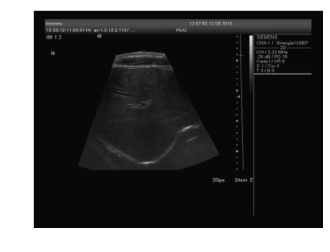

In [540]:
# Run example of video


videoIdx = 0 # Choose video to visualize
noFrames = 100 # Choose first noFrames to visualize

if noFrames > videosList[videoIdx].shape[0]:
    noFrames = videosList[videoIdx].shape[0]

vidShow=videosList[videoIdx][:noFrames]
for frame in range(noFrames):
    plt.imshow(vidShow[frame],cmap='gray')
    plt.show()
    clear_output(wait=True)

In [541]:
# Switch to interactive mode
#%matplotlib qt 

# ptsList=[]
# for vidIdx in range(len(videosList)):
#     plt.imshow(videosList[vidIdx][0]>10,cmap='gray')
#     pts=plt.ginput(4)
#     ptsList.append(np.array(pts))
#     plt.show()
#     plt.close()
# ptsArray = np.array(ptsList).astype(np.float32)
# np.savez('transPts',ptsArray)

# Switch back to inline mode
#%matplotlib inline 

In [542]:
# Load the points used for afine tranformation -- Found with commented code above 
ptsArray = np.load('transPts.npz')["arr_0"]
print(ptsArray.shape)

(7, 4, 2)


In [543]:
# Transfor all videos have the same field of view as the agreed upon reference video
# We agree on a reference video which all other videos are transformed to, video 2, i.e. video index 1
refIdx=1
_ , refRows, refCols = videosList[refIdx].shape
refPts = ptsArray[refIdx]

videosTransList = []

for videoIdx,video in enumerate(videosList):
    if videoIdx!=refIdx:
        transPts = ptsArray[videoIdx]
        M = cv2.getPerspectiveTransform(transPts, refPts)
        
        framesTransList = []
        for frameIdx,frame in enumerate(video):
            frameTrans = cv2.warpPerspective(frame, M, (refCols, refRows))
            framesTransList.append(frameTrans)

        videosTransList.append(np.array(framesTransList))
    else: 
        # Append reference frame video without affine transformation
        videosTransList.append(video)

### Mask videos with binary morphology

In [544]:
# Creating mask for field of view and removing backgrounddisk = np.zeros((40,40))
element = skimage.draw.disk((20,20),9,shape=(40,40))

# Pick sigma for gaussian filter: 
sigma_for_gaussian_filter = (0,3,3)

disk[element]=1
morphsInput = []
videoMasks = []
videosTransMaskList = []

for vidIdx,vid in enumerate(videosTransList):
    vidThr = np.zeros(vid.shape[1:])
    for frameIdx,frame in enumerate(vid):
        vidThr+=frame>10
    morphInput=vidThr>0
    vidMask = morph.opening(morphInput,disk) # First opening
    vidMask = morph.closing(vidMask,disk) # Then closing
    morphsInput.append(morphInput)
    videoMasks.append(vidMask)
    tmp_blurred = ndimage.gaussian_filter(vid,sigma=sigma_for_gaussian_filter)
    videosTransMaskList.append(tmp_blurred*vidMask[None,:,:])

Text(0.5, 1.0, 'Final processed video')

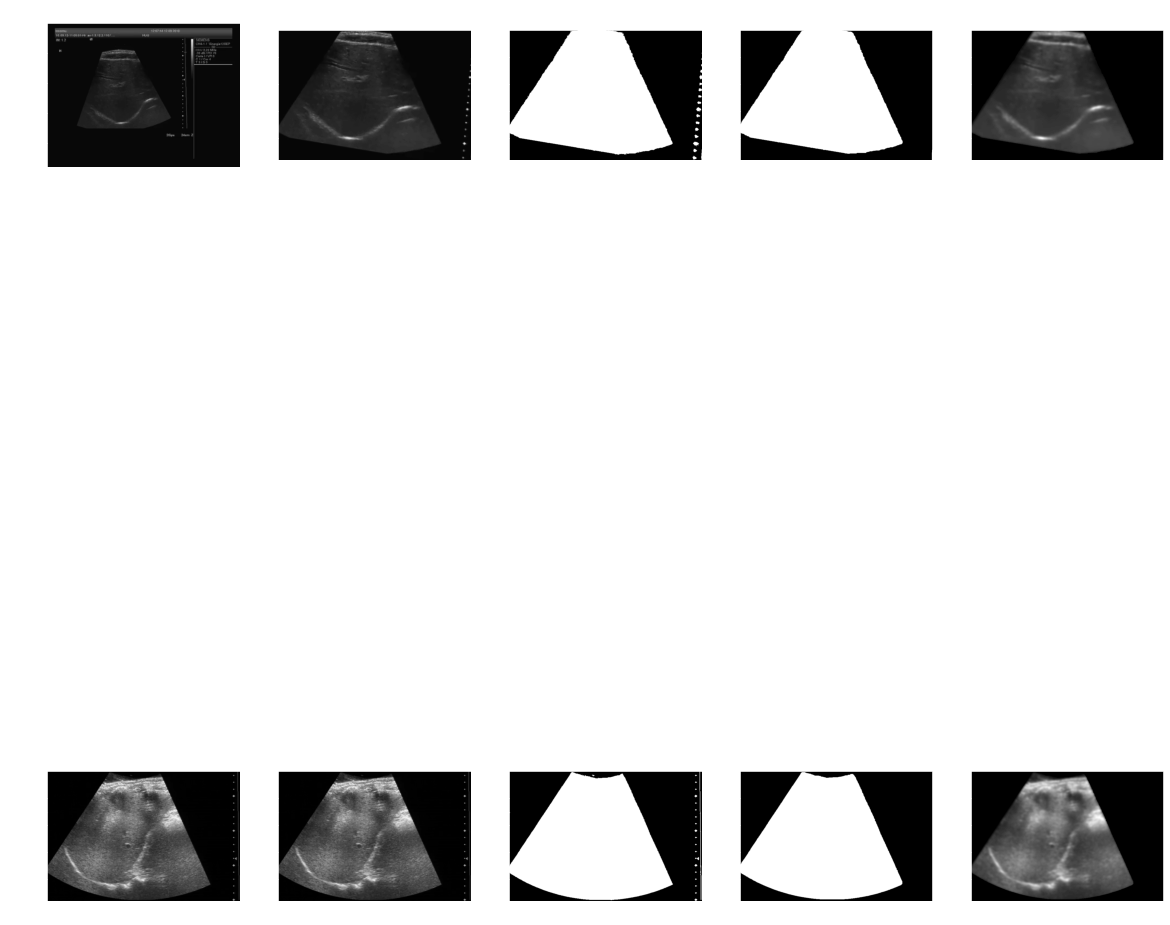

In [545]:
# Visualisation of final frames of final videos: 
fig,ax = plt.subplots(len(videosList),5,figsize=(20,25))
for vidIdx in range(len(videosList)):
        ax[vidIdx,0].imshow(videosList[vidIdx][0],cmap='gray')
        ax[vidIdx,1].imshow(videosTransList[vidIdx][0],cmap='gray')
        ax[vidIdx,2].imshow(morphsInput[vidIdx],cmap='gray')
        ax[vidIdx,3].imshow(videoMasks[vidIdx],cmap='gray')
        ax[vidIdx,4].imshow(videosTransMaskList[vidIdx][0],cmap='gray')
        ax[vidIdx,0].set_ylabel(f'Video {vidIdx+1}')
ax[0,0].set_title('Original video')
ax[0,1].set_title('Transformed video')
ax[0,2].set_title('Thresholded video')
ax[0,3].set_title('Mask')
ax[0,4].set_title('Final processed video')


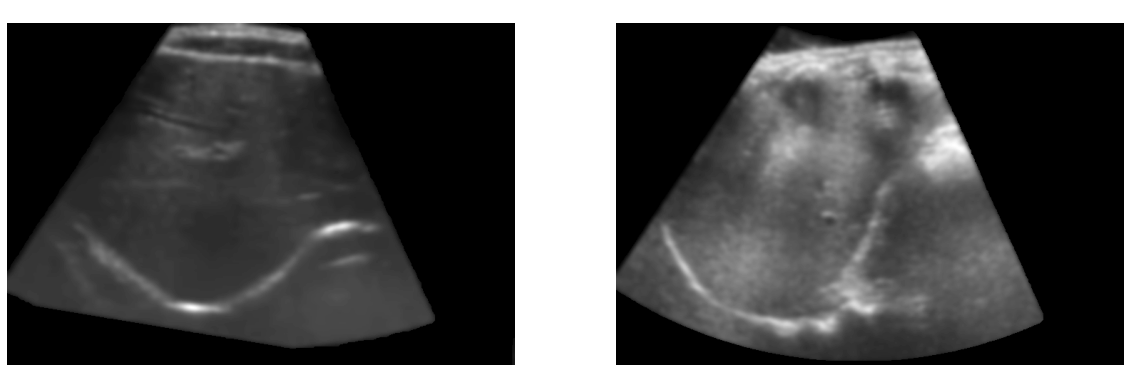

In [546]:
# Plot the first frame of each video in videosList in subplots
fig, axs = plt.subplots(1, len(videosTransMaskList), figsize=(20, 20))
for i in range(len(videosTransMaskList)):
    axs[i].imshow(videosTransMaskList[i][0], cmap='gray')
    axs[i].set_title(f'Video {i+1}')
    axs[i].axis('off')
plt.show()


    

# Setup model

In [547]:
import jax
import jax.numpy as jnp
import numpyro.distributions as dist
from jax import random
import time
from numpyro.infer import MCMC, NUTS, init_to_feasible

In [548]:
# Carry function
def f(carry, noise_t):
  beta, z_prev, tau = carry
  z_t = jnp.matmul(beta,z_prev)+noise_t
  z_prev = z_t
  return (beta, z_prev, tau), z_t

In [549]:
def model(T, T_forecast, output_dim, obs=None,latent_dim=2):

    """
    Define priors over beta, tau, sigma, z_1 (keep the shapes in mind)
    """

    beta = numpyro.sample(name="beta", fn=dist.Normal(loc=jnp.zeros((latent_dim,latent_dim)), scale=jnp.ones((latent_dim,latent_dim))))
    tau = numpyro.sample(name="tau", fn=dist.HalfCauchy(scale=jnp.ones(latent_dim)))
    sigma = numpyro.sample(name="sigma", fn=dist.HalfCauchy(scale=.1))
    z_prev = numpyro.sample(name="z_prev", fn=dist.Normal(loc=jnp.zeros(latent_dim), scale=jnp.ones(latent_dim)))
    h_matrix = numpyro.sample(name="h_matrix", fn=dist.Normal(loc=jnp.ones((output_dim,latent_dim)),scale=1))
    
    """
    Define LKJ prior
    """

    L_Omega = numpyro.sample("L_Omega", dist.LKJCholesky(latent_dim, 1.))
    Sigma_lower = jnp.matmul(jnp.diag(jnp.sqrt(tau)), L_Omega) # lower cholesky factor of the covariance matrix
    noises = numpyro.sample("noises", fn=dist.MultivariateNormal(loc=jnp.zeros(latent_dim), scale_tril=Sigma_lower), sample_shape=(T+T_forecast-1,))
    
    """
    Propagate the dynamics forward using jax.lax.scan
    """

    carry = (beta, z_prev, tau)
    z_collection = [z_prev]
    carry, zs_exp = jax.lax.scan(f, carry, noises, T+T_forecast-1)
    z_collection = jnp.concatenate((jnp.array(z_collection), zs_exp), axis=0)
    
    """
    Sample the observed y (y_obs) and missing y (y_mis)
    """
    #print('z_col shape', z_collection.shape)
    #print("z2", z_collection[2])
    #print((jnp.matmul(h_matrix, z_collection[:T].T)).T)
    #print("H", h_matrix.shape)
    #print("z", z_collection[:T].T.shape)
    #mu = jnp.matmul(h_matrix, z_collection[:T].T).T
    #print("mu", jnp.nan_to_num(mu))  

    numpyro.sample(name="y_obs", fn=dist.Normal(loc=(jnp.nan_to_num(jnp.matmul(h_matrix, z_collection[:T].T)).T), scale = sigma), obs=obs)
    numpyro.sample(name="y_pred", fn=dist.Normal(loc=(jnp.nan_to_num(jnp.matmul(h_matrix, z_collection[T:].T)).T), scale = sigma), obs=None) 
 

    return z_collection

# Test model with sin curves

In [494]:
N = 144
test_x = np.linspace(0,10,N)
test_y = 40*np.sin(test_x)

for i in range (1,4):
    test_y = np.vstack((test_y, 40*np.sin(i/2*test_x) + np.random.normal(0,0.5,N)))


In [495]:
t0 = time.time()


rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

nuts_kernel = NUTS(model=model,init_strategy=init_to_feasible())
mcmc_sin = MCMC(nuts_kernel, num_samples=1000, num_warmup=1000, num_chains=1)

mcmc_sin.run(rng_key_, T=N, T_forecast=100, output_dim=test_y.T.shape[1], obs=test_y.T)

t_fin = time.time()

print("Total time: {0:.3f}m".format((t_fin - t0)/60))

sample: 100%|██████████| 2000/2000 [03:39<00:00,  9.10it/s, 1023 steps of size 5.66e-04. acc. prob=0.91]


Total time: 3.697m


In [ ]:
mcmc_sin.print_summary()

(1000, 100, 4)


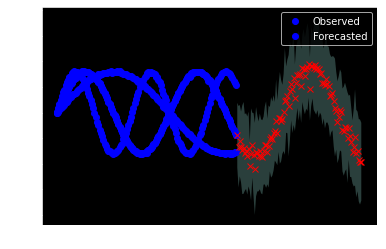

In [536]:
samples = {k:v for k, v in mcmc_sin.get_samples().items()}
print(samples['y_pred'].shape)

# get mean and standard devitions for predictions
y_mean = samples["y_pred"][:,:,2].mean(axis=0)
y_std = samples["y_pred"][:,:,2].std(axis=0)

y_pred_025 = y_mean - 1.96*y_std
y_pred_975 = y_mean + 1.96*y_std

plt.plot(range(N),test_y.T,"bo")
plt.plot(range(N,N+100),y_mean.T,"rx")
plt.fill_between(range(N,N+100), y_pred_025, y_pred_975, alpha=0.3)
plt.legend(["Observed","Forecasted"])
plt.show()


# Model for videoData

In [551]:

temp = np.array(videosTransMaskList[0][0:220,200:210,200:210])
temp = temp / 255
tmp_mean = temp.mean()
temp -= tmp_mean
temp = temp.reshape(temp.shape[0],-1)

t0 = time.time()
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

nuts_kernel = NUTS(model=model,init_strategy=init_to_feasible())
mcmc = MCMC(nuts_kernel, num_samples=1000, num_warmup=1000, num_chains=1)
mcmc.run(rng_key_, T=temp.shape[0], T_forecast=60, output_dim=temp.shape[1], obs=temp,latent_dim=10)

t_fin = time.time()

print("Total time: {0:.3f}m".format((t_fin - t0)/60))

sample: 100%|██████████| 2000/2000 [30:51<00:00,  1.08it/s, 1023 steps of size 2.49e-04. acc. prob=0.59]  


Total time: 30.979m


In [554]:
samples = {k:v for k, v in mcmc.get_samples().items()}
print(samples['y_pred'].shape)

baseline = videosTransMaskList[0][220:,200:210,200:210]/255
mean_samples = samples["y_pred"].mean(axis=0)
print(mean_samples.shape)
print(baseline.shape)

(1000, 60, 100)
(60, 100)
(60, 10, 10)


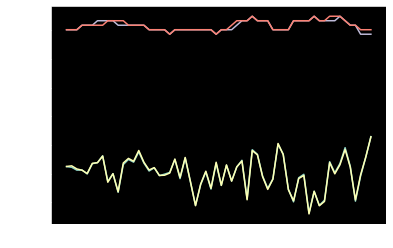

In [555]:
px_values_pred = mean_samples[:,[2,3]]
px_values_base = baseline.reshape(baseline.shape[0],-1)[:,[2,3]]

plt.plot(px_values_pred)
plt.plot(px_values_base)

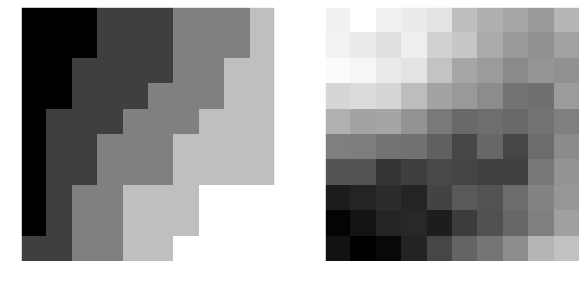

In [564]:
videoIdx = 0 # Choose video to visualize
noFrames = 60 # Choose first noFrames to visualize

if noFrames > videosList[videoIdx].shape[0]:
    noFrames = videosList[videoIdx].shape[0]

vidShow=videosList[videoIdx][:noFrames]

for frame in range(noFrames):
    fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
    ax1.imshow(baseline[frame,:].reshape(10,10),cmap='gray')
    ax2.imshow(mean_samples[frame].reshape(10,10),cmap='gray')
    plt.show()
    clear_output(wait=True)

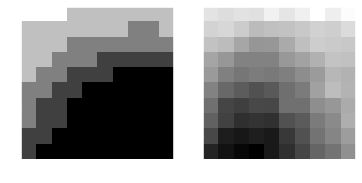

In [568]:
%matplotlib inline
fig,(ax1,ax2) = plt.subplots(1,2)
ax1.imshow(baseline[6,:].reshape(10,10),cmap='gray')
ax2.imshow(mean_samples[6].reshape(10,10),cmap='gray') 
plt.show()

In [570]:
print(mean_samples.shape)
print(baseline.shape)

(60, 100)
(60, 10, 10)


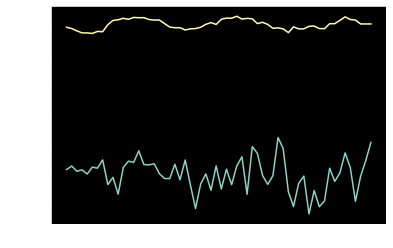

In [573]:
mean_frame_pred = mean_samples.mean(axis=1)
mean_frame_base = baseline.mean(axis=(1,2))

plt.plot(mean_frame_pred)
plt.plot(mean_frame_base)

In [520]:
samples.keys()

dict_keys(['L_Omega', 'beta', 'h_matrix', 'noises', 'sigma', 'tau', 'y_pred', 'z_prev'])

In [524]:
samples['h_matrix'].shape
print(samples['beta'].shape)

(1000, 2, 2)


<AxesSubplot:ylabel='Count'>

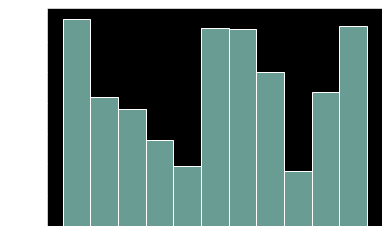

In [534]:
beta = samples['beta']

sns.histplot(beta[:,1,1])

(1000, 25, 2) h_matrix


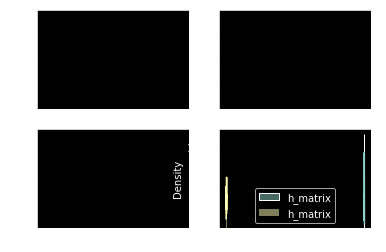

(1000, 2) tau


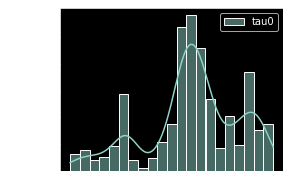

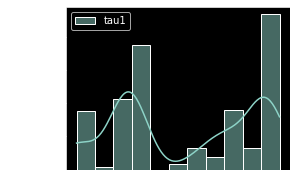

(1000, 2, 2) beta


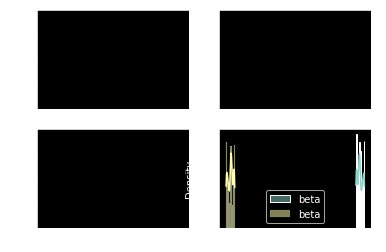

In [522]:
import seaborn as sns
nodes = ["h_matrix", "tau","beta"]
for node in nodes:
  if node in ("tau"):
    print(samples[node].shape,node)
    for i in range(2):
      plt.figure(figsize=(4,3))
      sns.histplot(samples[node][:,i], label=node+"%d"%i, kde=True, stat="density")
      plt.legend()
    plt.show()
  else:
    print(samples[node].shape,node)
    fig, axs = plt.subplots(2,2)
    for i in range(2):
      axs[i] = sns.histplot(samples[node][:,i,i], label=node, kde=True, stat="density")
    plt.legend()
    plt.show()